# Data Source: https://www.kaggle.com/ryanxjhan/cbc-news-coronavirus-articles-march-26/version/1

# Question:Has the news media been overreacting or under-reacting during the development of COVID-19?

# Import required Libraries

In [240]:

import numpy as np 
import pandas as pd 
from time import time
import re
import string
import os
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from nltk.stem import PorterStemmer
import string, re
import random

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.externals import joblib
import pickle

import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rajla\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rajla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [168]:
# Read data
df = pd.read_csv(r"C:\Users\rajla\Desktop\news_csvfile\news.csv")
df.head(3)

Unnamed: 0                   authors  \
0  0           ['Cbc News']               
1  1           ['Cbc News']               
2  2           ['The Associated Press']   

                                                                title  \
0  Coronavirus a 'wake-up call' for Canada's prescription drug supply   
1  Yukon gov't names 2 possible sources of coronavirus exposure         
2  U.S. Senate passes $2T coronavirus relief package                    

          publish_date  \
0  2020-03-27 08:00:00   
1  2020-03-27 01:45:00   
2  2020-03-26 05:13:00   

                                                                                                                                                                                                                                                description  \
0  Canadian pharmacies are limiting how much medication can be dispensed to try to prevent shortages, recognizing that most active ingredients for drugs come from India and China and medical supply chains have been disrupted by the spread of COVID-19.   
1  The Yukon government has identified two places in Whitehorse — a church and a dental clinic — where people may have been exposed to the coronavirus in recent weeks.                                                                                       
2  The Senate has passed an unparalleled $2.2 trillion economic rescue package steering aid to businesses, workers and health care systems engulfed by the coronavirus pandemic                                                                               

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [3]:
def plot_10_most_common_words(count_data, count_vectorizer):  
    words = count_vectorizer.get_feature_names()  
    total_counts = np.zeros(len(words))  
    for t in count_data:  
        total_counts+=t.toarray()[0] 
        count_dict = (zip(words, total_counts))  
        count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]  
        words = [w[0] for w in count_dict]  
        counts = [w[1] for w in count_dict]  
        x_pos = np.arange(len(words))   
     
    plt.figure(2, figsize=(15, 15/1.6180))  
    plt.subplot(title='10 most common words')  
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})  
    sns.barplot(x_pos, counts, palette='husl')  
    plt.xticks(x_pos, words, rotation=90)   
    plt.xlabel('words')  
    plt.ylabel('counts')  
    plt.show()

In [4]:
count_vectorizer = CountVectorizer(stop_words='english')  
count_data = count_vectorizer.fit_transform(df['text'])

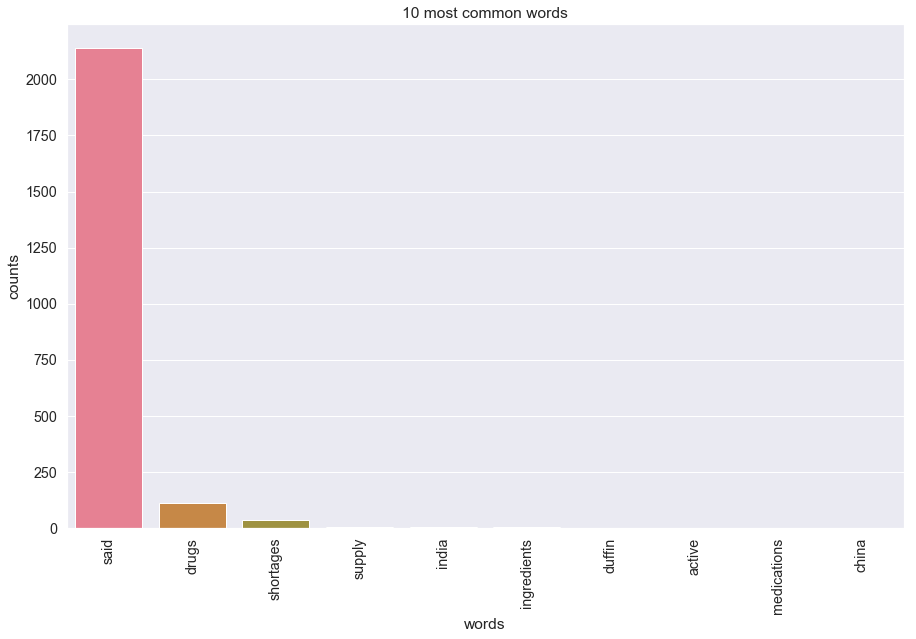

In [5]:
plot_10_most_common_words(count_data, count_vectorizer)  

# Above graph shows the frequency of irrelevent words as well, hence Text pre-procssing is required.

# Text Pre-processing 

In [6]:
class TextCounts(BaseEstimator, TransformerMixin):
    def count_regex(self, pattern, comments):
        return len(re.findall(pattern, comments))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x))
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the text
        df = pd.DataFrame({'count_words': count_words
                           ,'count_mentions': count_mentions
                           ,'count_hashtags': count_hashtags
                           ,'count_capital_words': count_capital_word
                           ,'count_excl_quest_marks': count_excl_quest_marks
                           ,'count_urls': count_urls
                          })
        return df
tc = TextCounts()

In [169]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')
        # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab) 
    
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        stopwords_list.append('said')
        stopwords_list.append('say')
        stopwords_list.append('come')
        stopwords_list.append('may')
        stopwords_list.append('says')
        stopwords_list.append('also')
        stopwords_list.append('The')
        stopwords_list.append('people')
        stopwords_list.append('It')
        stopwords_list.append('would')
        stopwords_list.append('like')
        stopwords_list.append('But')
        stopwords_list.append('one')
        stopwords_list.append('He')
        stopwords_list.append('could')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words)
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X


In [170]:
ct = CleanText()
sr_clean = ct.fit_transform(df.text)
sr_clean.sample(1)

3179    updat march today govern announc student children daycar leav canada must go self isol day return revers comment made march educ minist zach churchil new rule appli public sector worker detail avail text old stori march student feel well travel abroad march break nova scotia educ minist student back class zach churchil made comment wednesday follow news neighbour new brunswick advis famili keep student home two week travel intern covid concern take advic chief medic offic advic right anyon come back symptomat self isol not show churchil told report march break run march year cbc explainswhat know know coronaviru outbreak amid coronaviru fear pharmacist soap water better hand sanit churchil mandatori quarantin not tabl moment actual look attend polici want discourag anybodi stay home actual look potenti not attend impact case no covid case nova scotia world health organ declar covid pandem wednesday march no confirm case nova scotia timelin covid case across canada get paid self

In [171]:
def plot_10_most_common_words(count_data, Tfidf):  
    words = Tfidf.get_feature_names()  
    total_counts = np.zeros(len(words))  
    for t in count_data:  
        total_counts+=t.toarray()[0] 
        count_dict = (zip(words, total_counts))  
        count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]  
        words = [w[0] for w in count_dict]  
        counts = [w[1] for w in count_dict]  
        x_pos = np.arange(len(words))   
     
    plt.figure(2, figsize=(15, 15/1.6180))  
    plt.subplot(title='10 most common words')  
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})  
    sns.barplot(x_pos, counts, palette='husl')  
    plt.xticks(x_pos, words, rotation=90)   
    plt.xlabel('words')  
    plt.ylabel('counts')  
    plt.show()

In [172]:
Tfidf = TfidfVectorizer()
count_data = Tfidf.fit_transform(sr_clean)

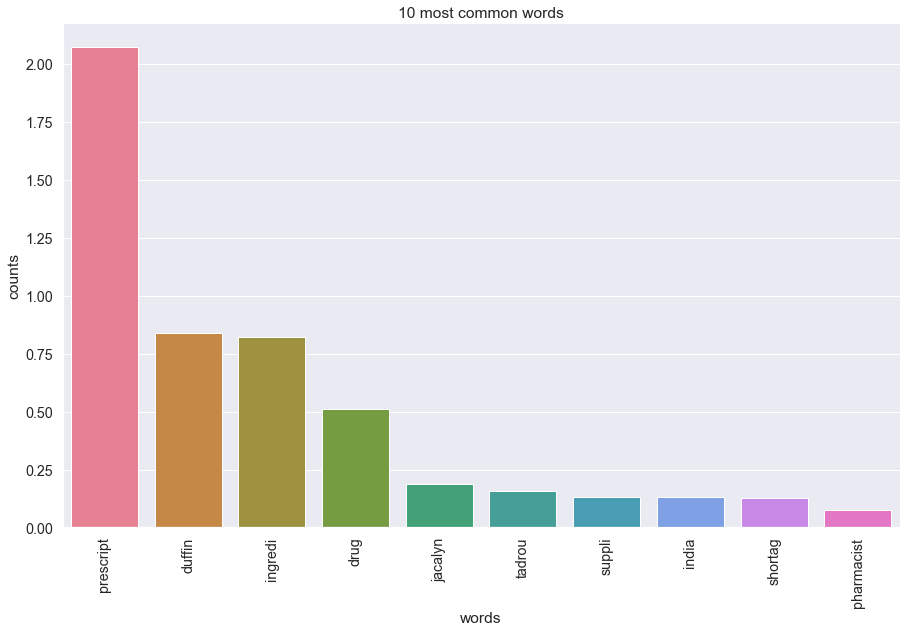

In [173]:
plot_10_most_common_words(count_data, Tfidf)  

# After cleaning more relevent words are appearing in the frequency chart

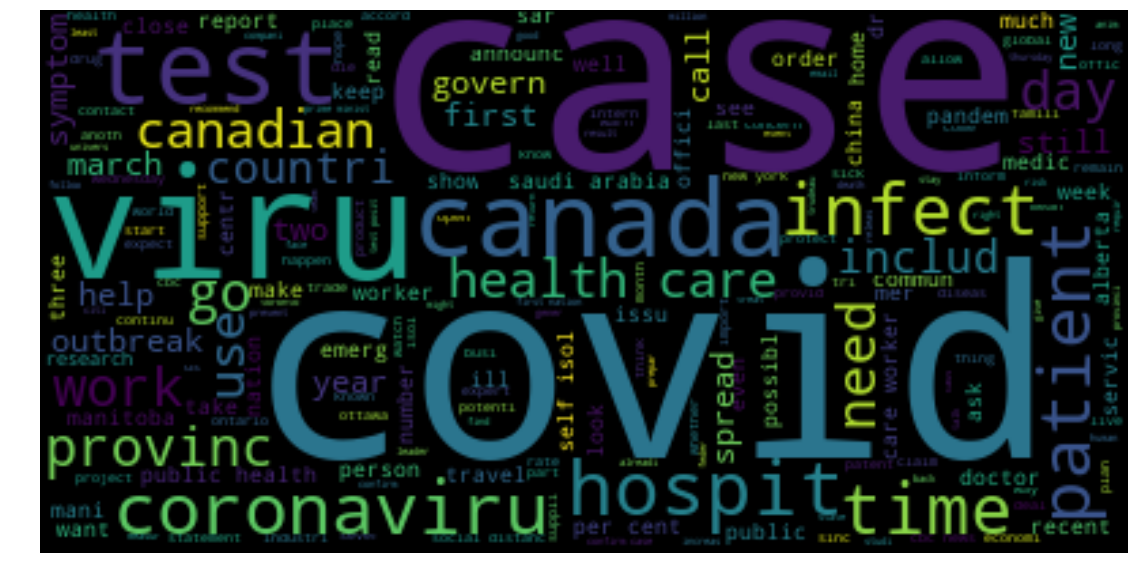

In [174]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(str(sr_clean))
# Display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# The question talks about the reaction of media during the development of COVID- 19, hence for the purpose, data was divided into three sets:

1.Jan and before data*

2.Februray data

3.March data

*As first case of COVID 19 appeared in China during November , so the data after 1st Nov 2019 was considered for the study.

In [175]:
df['sr_clean'] = sr_clean

In [176]:
df_2 = df[df.publish_date > '2019-11-01 00:00:00']

# Categorizing data based on Months (as COVID 19 developed)

In [177]:
#News in January and before
df_Janandbefore_News = df_2[df_2.publish_date < '2020-02-01 00:00:00']
len(df_Janandbefore_News)

185

In [178]:
#News in Feb 
df_Feb_News = df_2[(df_2.publish_date < '2020-03-01 00:00:00') & (df_2.publish_date > '2020-01-01 00:00:00')]
len(df_Feb_News)

582

In [179]:
#News in March
df_March_News = df_2[df_2.publish_date > '2020-02-01 00:00:00']
len(df_March_News)

3350

# Topic Modeling 

January and before News Titles

In [180]:
Tfidf = TfidfVectorizer()
count_data = Tfidf.fit_transform(df_Janandbefore_News.sr_clean)

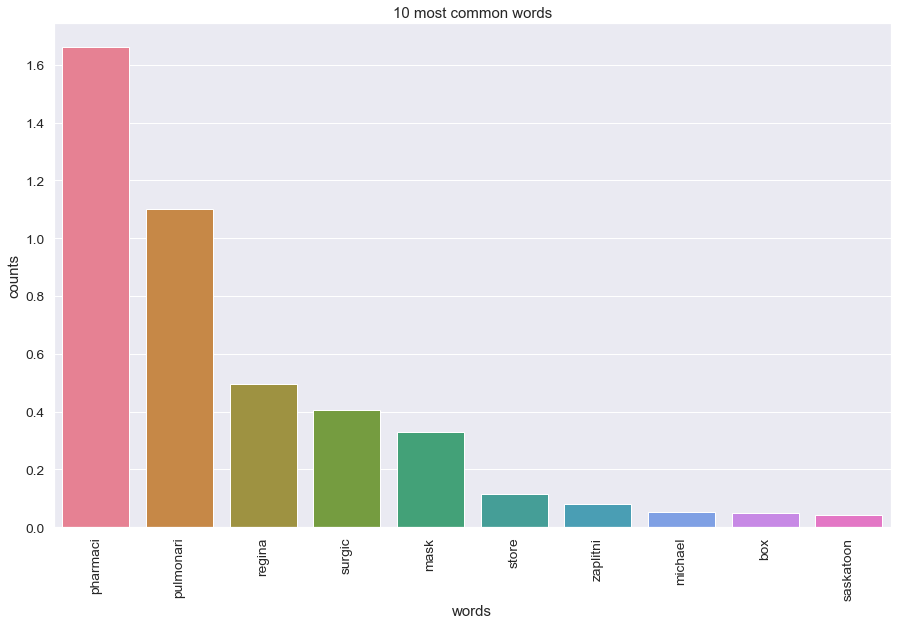

In [181]:
plot_10_most_common_words(count_data, Tfidf)

In [182]:
cv= TfidfVectorizer(max_df=0.95, min_df=2)
dtm = cv.fit_transform(df_Janandbefore_News.sr_clean)

In [183]:
dtm

<185x3194 sparse matrix of type '<class 'numpy.float64'>'
	with 40837 stored elements in Compressed Sparse Row format>

# Topic modeling using NMF Algorithm

In [184]:
from sklearn.decomposition import NMF

In [185]:
nmf_model = NMF(n_components=7,random_state=42)

In [186]:
nmf_model.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=7, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [187]:
len(cv.get_feature_names())

3194

In [188]:
for i in range(10):
    random_word_id = random.randint(0,3198)
    print(cv.get_feature_names()[random_word_id])

houssin
complet
combat
singh
strike
watch
garcia
prepar
hold
donat


In [189]:
len(nmf_model.components_)

7

In [190]:
len(nmf_model.components_[0])

3194

In [191]:
single_topic = nmf_model.components_[0]

In [192]:
single_topic.argsort()

array([1596, 2876, 1564, ...,  934, 3151,  479], dtype=int64)

In [193]:
top_word_indices = single_topic.argsort()[-10:]

In [194]:
for index in top_word_indices:
    print(cv.get_feature_names()[index])

govern
citi
foreign
hubei
canadian
flight
china
evacu
wuhan
citizen


In [195]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['lockdown', 'minist', 'provinc', 'daughter', 'plan', 'govern', 'citi', 'foreign', 'hubei', 'canadian', 'flight', 'china', 'evacu', 'wuhan', 'citizen']


THE TOP 15 WORDS FOR TOPIC #1
['davi', 'airlift', 'patti', 'emerg', 'champagn', 'trudeau', 'not', 'china', 'health', 'canada', 'minist', 'govern', 'declar', 'canadian', 'hajdu']


THE TOP 15 WORDS FOR TOPIC #2
['canada', 'confirm', 'viru', 'hospit', 'henri', 'public', 'dr', 'offic', 'symptom', 'offici', 'patient', 'test', 'toronto', 'case', 'health']


THE TOP 15 WORDS FOR TOPIC #3
['czech', 'hand', 'year', 'wear', 'suppli', 'event', 'demand', 'store', 'protect', 'order', 'face', 'pharmaci', 'sold', 'ottawa', 'mask']


THE TOP 15 WORDS FOR TOPIC #4
['spread', 'travel', 'pneumonia', 'diseas', 'chines', 'human', 'health', 'sar', 'case', 'caus', 'viru', 'outbreak', 'wuhan', 'china', 'new']


THE TOP 15 WORDS FOR TOPIC #5
['territori', 'compani', 'impact', 'canada', 'oper', 'banff', 'tourist', 'chwin', 'touri

In [196]:
topic_results = nmf_model.transform(dtm)

In [197]:
df_Janandbefore_News['Topic'] = topic_results.argmax(axis=1)

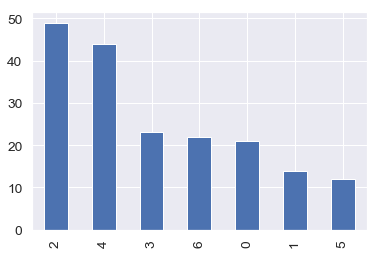

In [198]:
df_Janandbefore_News['Topic'].value_counts().plot('bar')

# Topic# 2 has highest frquecny

THE TOP 15 WORDS FOR TOPIC #2

['canada', 'confirm', 'viru', 'hospit', 'henri', 'public', 'dr', 'offic', 'symptom', 'offici', 'patient', 'test', 'toronto', 'case', 'health']

In [201]:
text = df_Janandbefore_News.text[(df_Janandbefore_News['Topic']==2)]

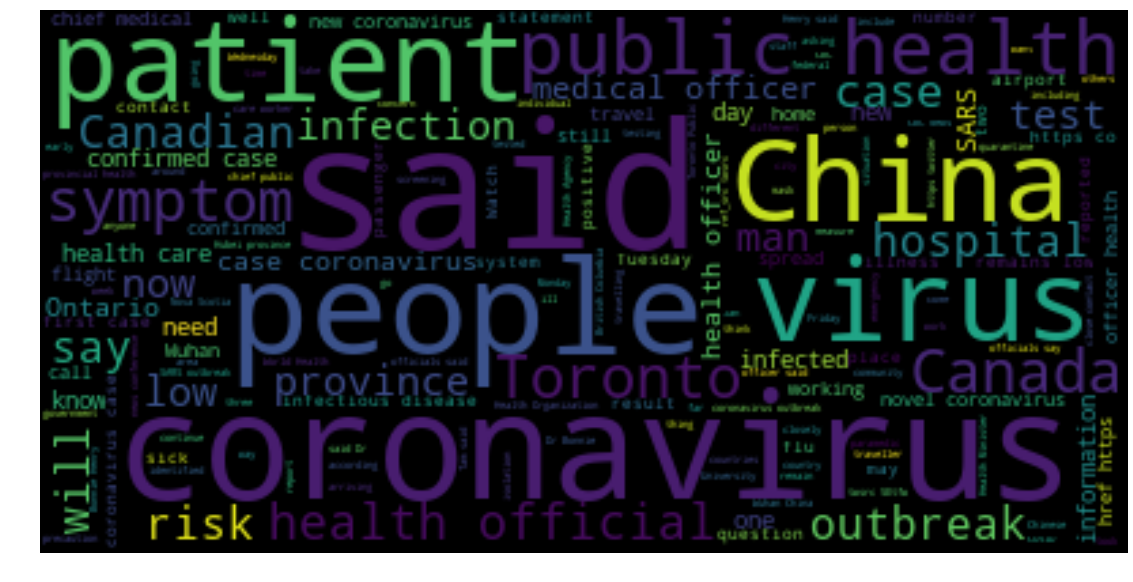

In [202]:

# Visualizing the prominant words

wordcloud = WordCloud().generate(str(text))
# Display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Februrary News Title

In [203]:
#df_Feb_News.head()

In [204]:
count_data = Tfidf.fit_transform(df_Feb_News.sr_clean)

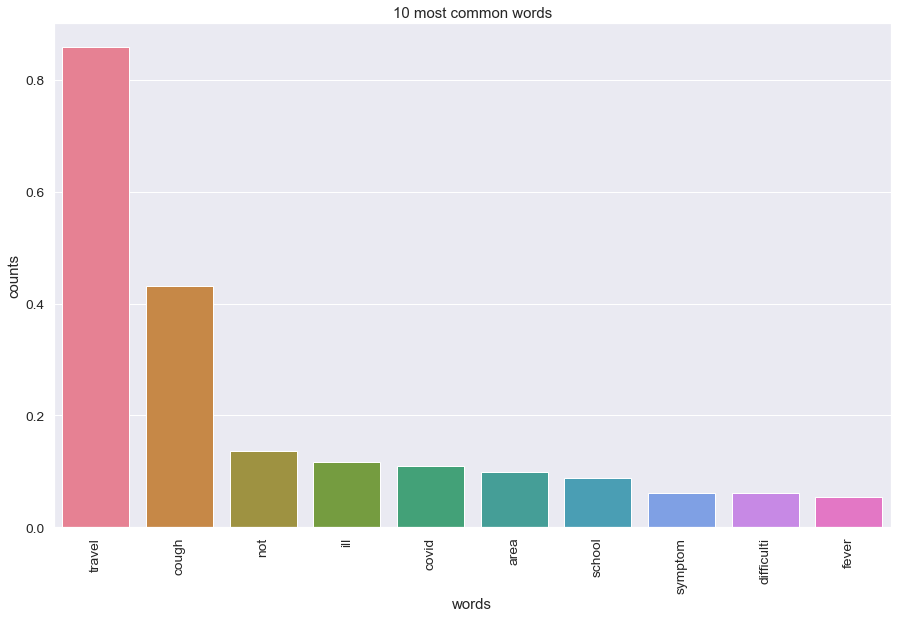

In [205]:
plot_10_most_common_words(count_data, Tfidf)

In [206]:
cv= TfidfVectorizer(max_df=0.95, min_df=2)
dtm_feb = cv.fit_transform(df_Feb_News.sr_clean)

In [207]:
dtm_feb

<582x6517 sparse matrix of type '<class 'numpy.float64'>'
	with 143365 stored elements in Compressed Sparse Row format>

In [208]:
nmf_model.fit(dtm_feb)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=7, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [209]:
len(cv.get_feature_names())

6517

In [210]:
for i in range(10):
    random_word_id = random.randint(0,6520)
    print(cv.get_feature_names()[random_word_id])

brought
purportedli
transmiss
misfortun
shorten
immedi
moon
request
vow
barrier


In [211]:
single_topic_feb = nmf_model.components_[0]

In [212]:
top_word_indices_feb = single_topic_feb.argsort()[-10:]

In [213]:
for index in top_word_indices_feb:
    print(cv.get_feature_names()[index])

chines
report
sar
citi
outbreak
viru
case
new
wuhan
china


In [214]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 20 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print('\n')

THE TOP 20 WORDS FOR TOPIC #0
['hospit', 'diseas', 'confirm', 'caus', 'infect', 'hong', 'kong', 'death', 'spread', 'health', 'chines', 'report', 'sar', 'citi', 'outbreak', 'viru', 'case', 'new', 'wuhan', 'china']


THE TOP 20 WORDS FOR TOPIC #1
['disembark', 'westerdam', 'coupl', 'posit', 'crew', 'nav', 'trenton', 'aboard', 'japanes', 'test', 'board', 'canadian', 'cornwal', 'japan', 'diamond', 'princess', 'quarantin', 'passeng', 'cruis', 'ship']


THE TOP 20 WORDS FOR TOPIC #2
['fear', 'bond', 'month', 'econom', 'investor', 'read', 'bank', 'product', 'rate', 'china', 'stock', 'economi', 'compani', 'impact', 'busi', 'price', 'year', 'market', 'per', 'cent']


THE TOP 20 WORDS FOR TOPIC #3
['huang', 'home', 'evacu', 'champagn', 'citizen', 'affair', 'charter', 'quarantin', 'hajdu', 'minist', 'trenton', 'leav', 'famili', 'plane', 'govern', 'wuhan', 'canada', 'china', 'flight', 'canadian']


THE TOP 20 WORDS FOR TOPIC #4
['viru', 'hospit', 'provinc', 'medic', 'chief', 'ontario', 'low', 'tes

In [215]:
topic_results_feb = nmf_model.transform(dtm_feb)

In [216]:
df_Feb_News['Topic'] = topic_results_feb.argmax(axis=1)

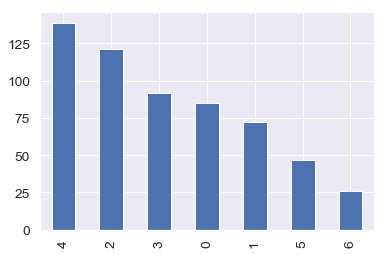

In [217]:
df_Feb_News['Topic'].value_counts().plot('bar')

# Topic#4 has the higest frequency:

THE TOP 20 WORDS FOR TOPIC #4

['viru', 'hospit', 'provinc', 'medic', 'chief', 'ontario', 'low', 'test', 'patient', 'offic', 'offici', 'dr', 'canada', 'symptom', 'travel', 'risk', 'toronto', 'case', 'public', 'health']



In [218]:
text_2 = df_Feb_News.text[(df_Feb_News.Topic==4)]

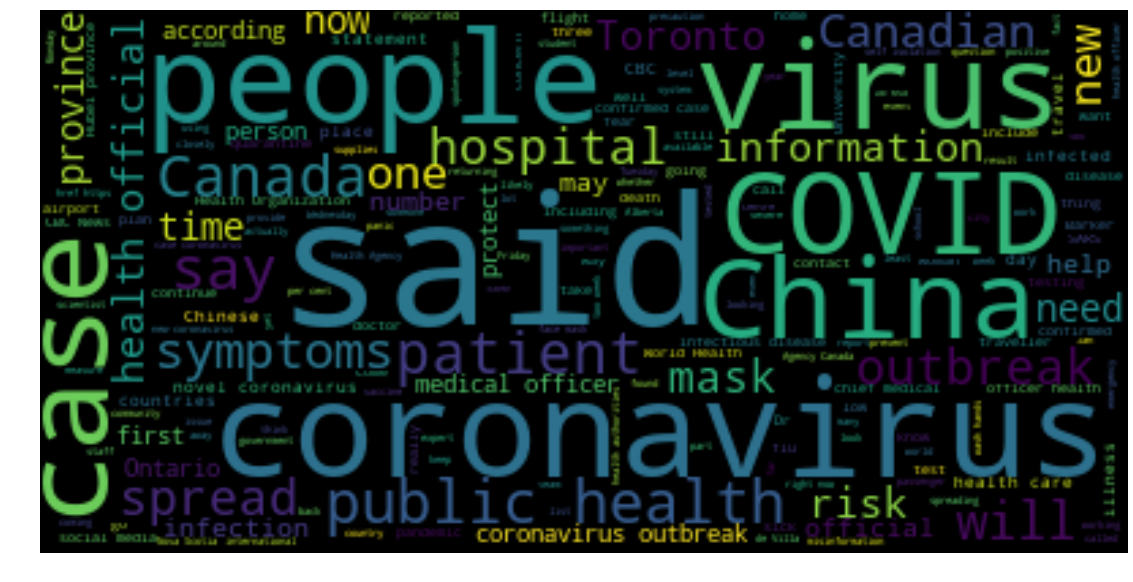

In [219]:
# Visualizing the prominant words

wordcloud = WordCloud().generate(str(text_2))
# Display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# March_News

In [220]:
#df_March_News.head()

In [221]:
count_data = Tfidf.fit_transform(df_March_News.sr_clean)

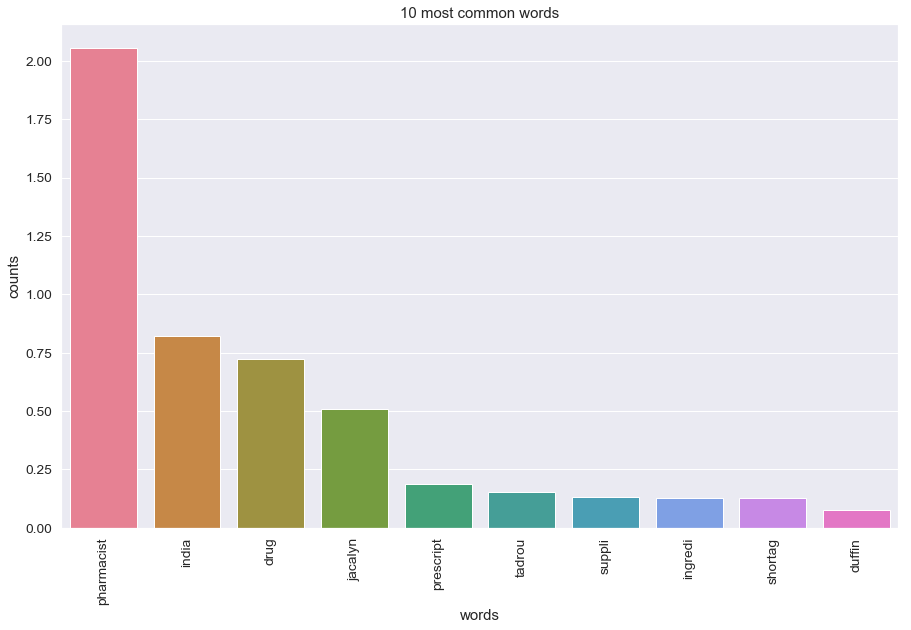

In [222]:
plot_10_most_common_words(count_data, Tfidf)

In [223]:
dtm_March = cv.fit_transform(df_March_News.sr_clean)

In [224]:
dtm_March

<3350x15170 sparse matrix of type '<class 'numpy.float64'>'
	with 760658 stored elements in Compressed Sparse Row format>

In [225]:
nmf_model.fit(dtm_March)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=7, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [226]:
len(cv.get_feature_names())

15170

In [227]:
single_topic_March = nmf_model.components_[0]

In [228]:
top_word_indices_March = single_topic_March.argsort()[-10:]

In [229]:
for index in top_word_indices_March:
    print(cv.get_feature_names()[index])

self
isol
travel
hospit
symptom
confirm
covid
test
health
case


In [230]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 20 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print('\n')

THE TOP 20 WORDS FOR TOPIC #0
['posit', 'new', 'region', 'woman', 'contact', 'man', 'public', 'provinc', 'patient', 'ontario', 'self', 'isol', 'travel', 'hospit', 'symptom', 'confirm', 'covid', 'test', 'health', 'case']


THE TOP 20 WORDS FOR TOPIC #1
['feder', 'order', 'minist', 'announc', 'not', 'measur', 'canadian', 'employe', 'worker', 'provinc', 'essenti', 'public', 'work', 'close', 'servic', 'emerg', 'busi', 'covid', 'govern', 'citi']


THE TOP 20 WORDS FOR TOPIC #2
['case', 'chines', 'trenton', 'viru', 'countri', 'travel', 'outbreak', 'diamond', 'japan', 'canada', 'princess', 'wuhan', 'flight', 'coronaviru', 'canadian', 'passeng', 'quarantin', 'china', 'cruis', 'ship']


THE TOP 20 WORDS FOR TOPIC #3
['travel', 'close', 'break', 'grade', 'campu', 'board', 'colleg', 'march', 'district', 'onlin', 'learn', 'trip', 'parent', 'cancel', 'teacher', 'educ', 'class', 'univers', 'school', 'student']


THE TOP 20 WORDS FOR TOPIC #4
['million', 'spend', 'billion', 'stock', 'rate', 'bank', '

In [231]:
topic_results_March = nmf_model.transform(dtm_March)

In [232]:
df_March_News['Topic'] = topic_results_March.argmax(axis=1)

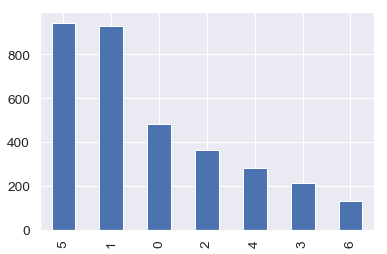

In [233]:
df_March_News['Topic'].value_counts().plot('bar')

# Topic # 5 & 1 respectively have highest frequency

THE TOP 20 WORDS FOR TOPIC #5

['pandem', 'hospit', 'social', 'help', 'cbc', 'make', 'store', 'time', 'use', 'sanit', 'health', 'care', 'covid', 'need', 'go', 'suppli', 'get', 'not', 'hand', 'mask']

THE TOP 20 WORDS FOR TOPIC #1

['feder', 'order', 'minist', 'announc', 'not', 'measur', 'canadian', 'employe', 'worker', 'provinc', 'essenti', 'public', 'work', 'close', 'servic', 'emerg', 'busi', 'covid', 'govern', 'citi']

In [234]:
text_3 = df_March_News.text[(df_March_News.Topic==5)]
text_4 = df_March_News.text[(df_March_News.Topic==1)]

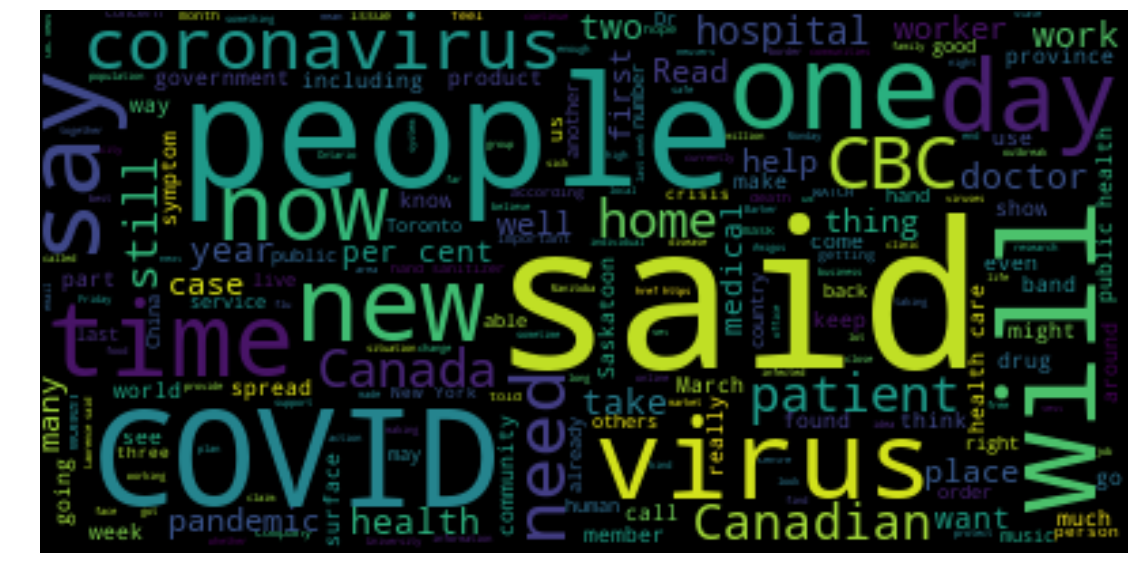

In [237]:
wordcloud = WordCloud().generate(str(text_3))
# Display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

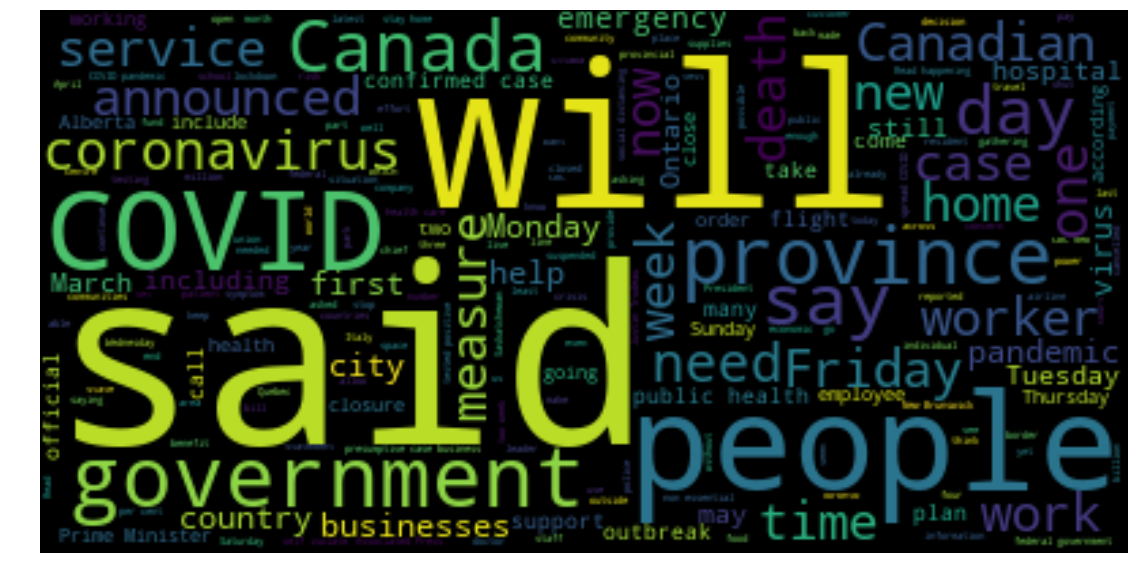

In [238]:
wordcloud = WordCloud().generate(str(text_4))
# Display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Topic Modleing with NMF algorithm is showing little different results in terms of no of topics appeared in the dataset. 

However, the end result is quite similar in terms of the questions asked in this project. We can see from the above result the media was quite active 
in reacting about coronavirus. This can not be said as over reaction because the virus was spreading like wildfire. 
 

# Reference

1.https://stackoverflow.com/questions/42068474/tfidfvectorizer-how-does-the-vectorizer-with-fixed-vocab-deal-with-new-words/42069027

2. https://towardsdatascience.com/testing-the-waters-with-nltk-3600574f891c

3. https://towardsdatascience.com/basic-binary-sentiment-analysis-using-nltk-c94ba17ae386

4. https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27
    
5. https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908